# Natural Posterior Network (Charpentier et al., 2022)

This notebook summarises the paper **Natural Posterior Network: Deep Bayesian Predictive Uncertainty for Exponential Family Distributions** (Charpentier et al., 2022).  
It also compares it with **Evidential Deep Learning** (Sensoy et al., 2018) and highlights what makes NatPN distinct.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet

## 1. Key Concepts

- NatPN models predictive uncertainty using a **Dirichlet posterior** over class probabilities.
- It introduces a **density model** (normalising flow) in the embedding space to estimate epistemic uncertainty.
- The total uncertainty is separated into:
  - **Aleatoric** (data noise/confusion)
  - **Epistemic** (lack of knowledge; low-density regions)
- The training loss is an **expected cross-entropy** (UCE) plus an **entropy regulariser** to avoid overconfidence.


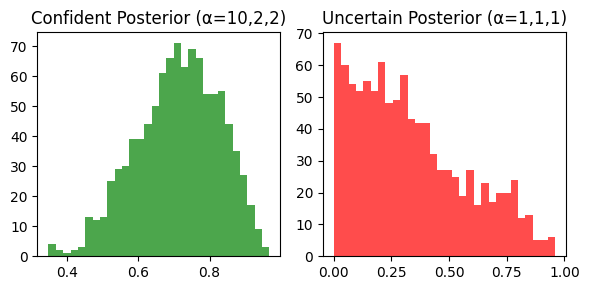

In [ ]:
# Compare a confident and an uncertain Dirichlet distribution
alpha_confident = [10, 2, 2]
alpha_uncertain = [1, 1, 1]

samples_conf = dirichlet(alpha_confident).rvs(1000)
samples_unc = dirichlet(alpha_uncertain).rvs(1000)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(samples_conf[:, 0], bins=30, color="green", alpha=0.7)
plt.title("Confident Posterior (a=10,2,2)")

plt.subplot(1, 2, 2)
plt.hist(samples_unc[:, 0], bins=30, color="red", alpha=0.7)
plt.title("Uncertain Posterior (a=1,1,1)")
plt.tight_layout()
plt.show()

## 2. Methodology

1. **Feature embedding**: an encoder network maps input x → z.  
2. **Density estimation**: a normalising flow models p(z) to quantify how likely a sample is.  
3. **Posterior formulation**:
   \[
   \alpha_{\text{post}}(x) = \alpha_{\text{prior}} + p(z)\,f(z)
   \]
   where f(z) is class evidence and p(z) controls confidence.  
4. **Loss**:
   \[
   L = \mathbb{E}_{\mu\sim\mathrm{Dir}(\alpha)}[\text{CE}(\mu, y)] - \lambda H[\mathrm{Dir}(\alpha)]
   \]
   The entropy term discourages over-confident predictions.


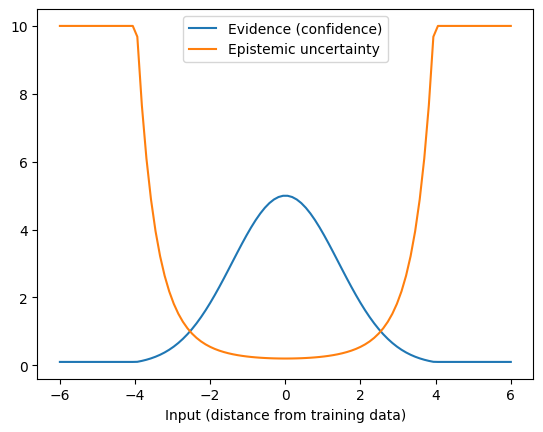

In [ ]:
from __future__ import annotations  # noqa: F404

import matplotlib.pyplot as plt
import numpy as np  # noqa: F811


def fake_density(x: np.ndarray) -> np.ndarray:
    """Simulated density: high near 0, low further away."""
    return np.exp(-(x**2) / 4.0)


def fake_evidence(x: np.ndarray) -> np.ndarray:
    """Evidence decreases as density decreases.

    Ensures a minimum evidence of 0.1.
    """
    return np.maximum(0.1, 5.0 * fake_density(x))


def main() -> None:
    x: np.ndarray = np.linspace(-6.0, 6.0, 100)
    evidence: np.ndarray = fake_evidence(x)
    uncertainty: np.ndarray = 1.0 / evidence

    plt.plot(x, evidence, label="Evidence (confidence)")
    plt.plot(x, uncertainty, label="Epistemic uncertainty")
    plt.xlabel("Input (distance from training data)")
    plt.legend()
    plt.title("Evidence vs Epistemic Uncertainty (Toy Example)")
    plt.show()


if __name__ == "__main__":
    main()

## 3. Comparison: NatPN vs Evidential Deep Learning

| Feature | Sensoy et al. (2018) | Charpentier et al. (2022) |
|----------|----------------------|-----------------------------|
| Distribution | Dirichlet over class probs | Dirichlet modulated by density |
| Evidence | Network output (ReLU/Softplus) | Evidence × embedding density |
| Epistemic handling | Implicit (low total evidence) | Explicit (low density → uncertainty) |
| Loss | Expected CE + regulariser | Expected CE + entropy term |
| Complexity | Simple | Adds normalising flow |

NatPN explicitly disentangles epistemic and aleatoric uncertainty, improving OOD detection and calibration.


## 4. Insights for Our Project

- Evidence-based Dirichlet outputs remain fast and interpretable.
- Density-aware modulation provides a better epistemic signal.
- Combine expected cross-entropy with an entropy penalty for stability.
- Test uncertainty using in-distribution and synthetic out-of-distribution data.


## 5. Summary

Natural Posterior Networks extend evidential learning by linking evidence strength to the data density in embedding space.  
This allows explicit control of epistemic uncertainty and better OOD detection.  
Compared to Sensoy et al. (2018), NatPN achieves more robust calibration at the cost of model complexity.


### References
- Charpentier B. et al. (2022). *Natural Posterior Network: Deep Bayesian Predictive Uncertainty for Exponential Family Distributions*.  
- Sensoy M., Kaplan L., Kandemir M. (2018). *Evidential Deep Learning to Quantify Classification Uncertainty*.
